In [ ]:
from bing_image_downloader import downloader

from lib.path import data_file_path

names = ['마동석', '카리나', '장원영', '하정우', '이하늬', '정경호']


In [ ]:
for name in names:
    downloader.download(
        query=name,
        limit=50,
        output_dir=data_file_path() / 'images',
        adult_filter_off=True,
        force_replace=False,
        timeout=30,
    )

In [ ]:
import os
import shutil
from pathlib import Path


def dataset_split(query, train_cnt):
    directory_list = [
        './dataset/train/',
        './dataset/test/',
    ]

    root = Path('../../')
    image_path = root / 'data' / 'images'

    for dir in directory_list:
        d = root / dir / query
        print(d)
        os.makedirs(d, exist_ok=True)

    path = image_path / query
    for cnt, file_name in enumerate(os.listdir(path)):
        if cnt < train_cnt:
            src = image_path / query / file_name
            dest = root / directory_list[0] / query / file_name
            print(f'trainset : {file_name}')
            shutil.copy(src, dest)
        else:
            src = image_path / query / file_name
            dest = root / directory_list[1] / query / file_name
            print(f'testset : {file_name}')
            shutil.copy(src, dest)

    # shutil.rmtree(query)


dataset_split('마동석', 40)
dataset_split('카리나', 40)
dataset_split('장원영', 40)

In [ ]:
from torchvision import transforms

transforms_train = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
transforms_test = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [ ]:
from torchvision import datasets

train_datasets = datasets.ImageFolder(
    root='../../dataset/train', transform=transforms_train
)
test_datasets = datasets.ImageFolder(
    root='../../dataset/test', transform=transforms_train
)

In [ ]:
train_datasets.classes

In [ ]:
len(train_datasets[0])

In [ ]:
image, label = train_datasets[0]

print(image, label)


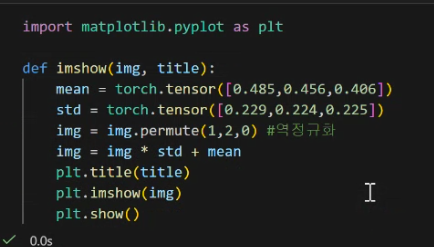

In [ ]:
import matplotlib.pyplot as plt
import torch


def imshow(image, title):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = image.permute(1, 2, 0)
    image = image * std + mean  # 역정규화
    # [0.485, 0.456, 0.406]
    # [0.229, 0.224, 0.225]
    plt.title(title)
    plt.imshow(image)  # permute 차원 순서 변경
    plt.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(train_datasets, shuffle=True, batch_size=4)
test_loader = torch.utils.data.DataLoader(test_datasets, shuffle=True, batch_size=4)

In [ ]:
import torchvision

data_iter = iter(train_loader)
images, labels = next(data_iter)

out_images = torchvision.utils.make_grid(images)

imshow(out_images, labels)

In [ ]:
from torchvision import models

weights = models.ResNet34_Weights.DEFAULT
model = models.resnet34(weights=weights)
model

In [ ]:
for name, module in model.named_parameters():
    print(name, module.requires_grad)

In [ ]:
for params in model.parameters():
    params.requires_grad = False  # 가중치를 고정 frozen


In [ ]:
from torch import nn

model.fc = nn.Linear(512, 3)  # 마지막 나올 fc만 수정 # 모델의 분류기만 바꿈
model

In [ ]:
from torch.utils.data import random_split

train_data_size = len(train_datasets)

# 8 : 2 train : 8 test : 2
train_size = int(train_data_size * 0.8)
val_size = train_data_size - train_size

print(f'train data size : {train_size} val data size : {val_size}')

train_dataset, val_dataset = random_split(train_datasets, [train_size, val_size])

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True
)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)


In [ ]:
import tqdm
from torch import optim

from lib.path import model_file_path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 20
model = model.to(device)
best_val_loss = 100000.0
stop_count = 3
early_stop_count = 0

for ep in range(epochs):
    for image, labels in tqdm.tqdm(train_data_loader):
        optimizer.zero_grad()
        preds = model(image.to(device))
        loss = criterion(preds, labels.to(device))
        loss.backward()
        optimizer.step()

    # ------------- validation 모의고사 시작 ----------------
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for img, labels in val_data_loader:
            img = img.to(device)
            labels = labels.to(device)
            pred = model(img)
            val_loss += criterion(pred, labels)

    total_val_loss = val_loss / len(val_data_loader)

    # --------- Early Stopping 할것인지 체크 --------------
    if total_val_loss < best_val_loss:
        early_stop_count = 0
        best_val_loss = total_val_loss
        torch.save(model.state_dict(), model_file_path('best_model.pth'))
    else:
        early_stop_count += 1

        if early_stop_count >= stop_count:
            break

    print(f'ep: {ep} loss : {loss.item()}')


In [ ]:
import tqdm
from torch import optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 20
model = model.to(device)

for ep in range(epochs):
    for image, labels in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        preds = model(image.to(device))
        loss = criterion(preds, labels.to(device))
        loss.backward()
        optimizer.step()

    print(f'ep: {ep} loss : {loss.item()}')


In [ ]:
model.eval()

with torch.no_grad():
    corrects = 0

    for image, labels in test_loader:
        preds = model(image.to(device))
        pred = torch.max(preds, 1)[1]

        corrects += torch.sum(pred == labels.to(device).data)

        image_grid = torchvision.utils.make_grid(image)
        print(labels)
        imshow(image_grid.cpu(), title=pred)

    acc = corrects / len(test_datasets.targets)
    print(f'정확도 : {acc}')


In [ ]:
weights = models.ResNet34_Weights.DEFAULT
model = models.resnet34(weights=weights)  # 재학습 시에는 새 모델로 학습

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = nn.Linear(512, 3)

In [ ]:
import torch

torch.cuda.is_available()
